In [ ]:
!uv sync

In [1]:
# save as test_cuda.py and run: python3 test_cuda.py

import platform

print("=== Environment ===")
print("Platform:", platform.platform())
print("Python:", platform.python_version())

try:
    import torch
except ImportError as e:
    print("\nPyTorch is not installed or not in this Python environment.")
    raise SystemExit(e)

print("\n=== PyTorch / CUDA Info ===")
print("torch.__version__:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)

cuda_available = torch.cuda.is_available()
print("torch.cuda.is_available():", cuda_available)

if not cuda_available:
    print("\nCUDA is NOT available to PyTorch in this environment.")
else:
    # Number of devices
    device_count = torch.cuda.device_count()
    print("torch.cuda.device_count():", device_count)

    for i in range(device_count):
        print(f"  device {i}: {torch.cuda.get_device_name(i)}")

    # Simple tensor test on GPU
    try:
        x = torch.rand(3, 3, device="cuda")
        y = torch.rand(3, 3, device="cuda")
        z = x @ y
        print("\nSuccessfully ran a matrix multiply on CUDA.")
        print("z.device:", z.device)
    except Exception as e:
        print("\nERROR: Allocation or compute on CUDA failed:")
        print(e)

print("\n=== Test Complete ===")

=== Environment ===
Platform: macOS-14.6.1-arm64-arm-64bit
Python: 3.11.5

=== PyTorch / CUDA Info ===
torch.__version__: 2.9.1
torch.version.cuda: None
torch.cuda.is_available(): False

CUDA is NOT available to PyTorch in this environment.

=== Test Complete ===


In [2]:
import torch
import numpy as np


print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())

2.9.1
None
None


In [3]:
import pandas as pd
from pathlib import Path

# Path to the small transactions CSV (relative to this notebook).
DATA_PATH = Path("dataset") / "HI-Small_Trans.csv"

# Load into a DataFrame
small_trans = pd.read_csv(DATA_PATH)

# Quick summary and preview
print(f"Loaded {len(small_trans)} rows; columns: {list(small_trans.columns)}")
small_trans.head()

Loaded 5078345 rows; columns: ['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering']


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [4]:
# Basic analysis: currencies, banks, and other summaries
# This cell is robust to different column names: it searches for currency-like and bank-like columns

# Show shape and a small sample
rows, cols = small_trans.shape
print(f"Data shape: {rows} rows x {cols} columns")
print()
print("Sample rows:")
display(small_trans.head())

# Missing values by column (top 10)
missing_by_col = small_trans.isnull().sum().sort_values(ascending=False).head(15)
print("Top missing values by column:")
print(missing_by_col.to_string())
print()

# Find likely currency column(s)
currency_candidates = [c for c in small_trans.columns if any(k in c.lower() for k in ('currency','ccy','curr'))]
if currency_candidates:
    cur_col = currency_candidates[0]
    num_currencies = small_trans[cur_col].nunique(dropna=True)
    top_currencies = small_trans[cur_col].value_counts().head(10)
    print(f"Found currency column: '{cur_col}' — {num_currencies} unique values")
    print("Top currencies (by count):")
    print(top_currencies.to_string())
else:
    cur_col = None
    print("No currency-like column found.")
    print("Columns:", list(small_trans.columns))

print()
# Find likely bank-related columns
bank_candidates = [c for c in small_trans.columns if any(k in c.lower() for k in ('bank','institution','bic','iban','bankid','bank_id','bankname','bank_name'))]
if bank_candidates:
    # Count unique bank identifiers across candidate columns
    unique_banks = set()
    for c in bank_candidates:
        unique_banks.update(small_trans[c].dropna().astype(str).unique())
    num_unique_banks = len(unique_banks)
    print(f"Found bank-like columns: {bank_candidates} — approx. {num_unique_banks} unique bank identifiers (aggregated)")
else:
    num_unique_banks = None
    print("No bank-like columns found.")

print()
# Other basic summaries: amount column candidates and top senders/receivers if available
amt_candidates = [c for c in small_trans.columns if any(k in c.lower() for k in ('amount','amt','value'))]
if amt_candidates:
    amt_col = amt_candidates[0]
    print(f"Found amount column: {amt_col} — summary:")
    print(small_trans[amt_col].describe())
else:
    print("No amount-like column found.")

# If sender/receiver columns exist, show top participants
party_candidates = [c for c in small_trans.columns if any(k in c.lower() for k in ('sender','receiver','originator','beneficiary','from_','to_','account'))]
if party_candidates:
    print()
    print("Top participants in party-like columns:")
    for c in party_candidates:
        print(f"Column: {c}")
# Final small sample
display(small_trans.sample(min(5, len(small_trans))))

Data shape: 5078345 rows x 11 columns

Sample rows:


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


Top missing values by column:
Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0

Found currency column: 'Receiving Currency' — 15 unique values
Top currencies (by count):
Receiving Currency
US Dollar      1879341
Euro           1172017
Swiss Franc     237884
Yuan            206551
Shekel          194988
Rupee           192065
UK Pound        181255
Ruble           157361
Yen             156319
Bitcoin         148151

Found bank-like columns: ['From Bank', 'To Bank'] — approx. 30470 unique bank identifiers (aggregated)

Found amount column: Amount Received — summary:
count    5.078345e+06
mean     5.988726e+06
std      1.037183e+09
min      1.000000e-06
25%      1.833700e+02
50%      1.411010e+03
75%      1.234627e+04
max      1.046302e+12
Name: Amount Received, dtype: float64

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
4937763,2022/09/10 06:51,1362,8001C9480,701,800F328D0,8089.94,US Dollar,8089.94,US Dollar,Credit Card,0
3386450,2022/09/07 06:04,1588,800337490,1588,800337490,464.52,Euro,544.31,US Dollar,ACH,0
2416668,2022/09/05 05:53,43049,81005E8B0,43049,8100DAAC0,7176.47,Shekel,7176.47,Shekel,Cheque,0
2101395,2022/09/04 01:09,21611,800CC99E0,1686,80E315A40,4073.91,US Dollar,4073.91,US Dollar,Cheque,0
1171397,2022/09/02 01:14,16,8047A72A0,3,804A14CF0,338423.55,Rupee,338423.55,Rupee,Credit Card,0


In [5]:
# convert hex account numbers to int
hex_to_int = np.vectorize(lambda x: int(x, 16))

# create adjacency lists to represent the graph
source = hex_to_int(small_trans['Account'])
target = hex_to_int(small_trans['Account.1'])

In [6]:
from torch_geometric.data import Data
import torch
import numpy as np

# Map account IDs to a compact 0..N-1 index space to avoid huge sparse IDs
# Concatenate unique accounts from source/target and factorize
all_accounts = np.concatenate([source, target])
unique_accounts, inverse_idx = np.unique(all_accounts, return_inverse=True)
num_nodes = unique_accounts.shape[0]
# Rebuild source/target as compact indices
source_idx = inverse_idx[:source.shape[0]]
target_idx = inverse_idx[source.shape[0]:]

# Build edge_index
edge_index = torch.tensor(np.vstack([source_idx, target_idx]), dtype=torch.long)

# Create Data object
data = Data(edge_index=edge_index, num_nodes=num_nodes)
print('num_nodes:', num_nodes, 'num_edges:', edge_index.size(1))
print(data)

num_nodes: 515080 num_edges: 5078345
Data(edge_index=[2, 5078345], num_nodes=515080)


In [11]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from torch_geometric.data import Data
import torch

# extract individual edge features
time = pd.to_datetime(small_trans['Timestamp']).astype('int64') / 1e9
amount_paid = small_trans['Amount Paid'].to_numpy()
amount_received = small_trans['Amount Received'].to_numpy()

# use one-hot encoding for categorical variables
paid_enc = OneHotEncoder(sparse_output=False)
paid_currency = paid_enc.fit_transform(small_trans['Payment Currency'].to_numpy().reshape(-1, 1))

received_enc = OneHotEncoder(sparse_output=False)
received_currency = received_enc.fit_transform(small_trans['Receiving Currency'].to_numpy().reshape(-1, 1))

format_enc = OneHotEncoder(sparse_output=False)
pay_format = format_enc.fit_transform(small_trans['Payment Format'].to_numpy().reshape(-1, 1))

# combine edge features into single tensor
numeric_features = np.column_stack([time, amount_paid, amount_received])
#edge_features = torch.from_numpy(np.concatenate([numeric_features, paid_currency, received_currency, pay_format], axis=1)).float()
edge_features = torch.from_numpy(numeric_features).float()

# create edge labels
fraud_label = torch.tensor(small_trans['Is Laundering'].to_numpy(), dtype=torch.long)

# attach features and labels to PyG Data
data.edge_attr = edge_features
data.edge_label = fraud_label
print(data)

Data(edge_index=[2, 5078345], num_nodes=515080, edge_attr=[5078345, 3], edge_label=[5078345], train_mask=[5078345], val_mask=[5078345], test_mask=[5078345], x=[515080, 1])


In [12]:
# chronological 60/20/20 split by edge index order
num_edges = data.edge_index.size(1)
train_end = int(0.6 * num_edges)
val_end = int(0.8 * num_edges)

train_mask = torch.zeros(num_edges, dtype=torch.bool)
val_mask = torch.zeros(num_edges, dtype=torch.bool)
test_mask = torch.zeros(num_edges, dtype=torch.bool)
train_mask[:train_end] = True
val_mask[train_end:val_end] = True
test_mask[val_end:] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask
print('Masks set:', train_mask.sum().item(), val_mask.sum().item(), test_mask.sum().item())

Masks set: 3047007 1015669 1015669


In [19]:
## Hyperparameters

pos_weight = 500.0 #how much more heavily to weight positive labels 

epochs = 20 #number of epochs in training loop

num_hid = 64 #how many hidden layers in NN

learn_rate = 1e-4 #

decay = 1e-4 #

#default pos_weight=1000.0, since there 1000 times fewer transactions with postive labeles

Epoch 01 | loss 116421408.0000 | train_acc 0.998 | val_acc 0.999 | val_precision 0.000 | val_recall 0.000 | false_pos 0.000
Epoch 02 | loss 106608368.0000 | train_acc 0.998 | val_acc 0.999 | val_precision 0.000 | val_recall 0.000 | false_pos 0.000
Epoch 04 | loss 87453744.0000 | train_acc 0.994 | val_acc 0.998 | val_precision 0.000 | val_recall 0.000 | false_pos 0.001
Epoch 06 | loss 68626344.0000 | train_acc 0.956 | val_acc 0.986 | val_precision 0.002 | val_recall 0.020 | false_pos 0.013
Epoch 08 | loss 50532788.0000 | train_acc 0.954 | val_acc 0.983 | val_precision 0.001 | val_recall 0.021 | false_pos 0.016
Epoch 10 | loss 32479176.0000 | train_acc 0.947 | val_acc 0.975 | val_precision 0.001 | val_recall 0.027 | false_pos 0.024
Epoch 12 | loss 15791600.0000 | train_acc 0.859 | val_acc 0.868 | val_precision 0.001 | val_recall 0.169 | false_pos 0.131
Epoch 14 | loss 16483966.0000 | train_acc 0.002 | val_acc 0.002 | val_precision 0.001 | val_recall 1.000 | false_pos 0.999
Epoch 16 | los

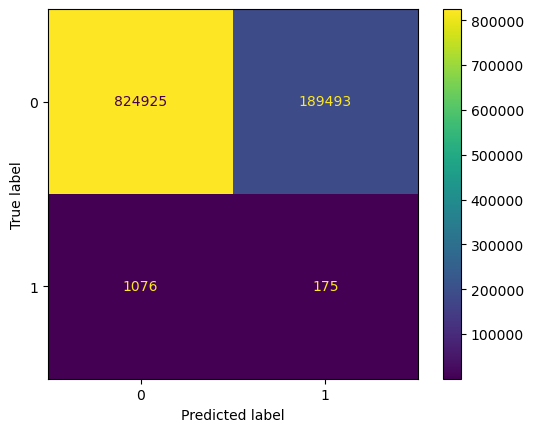

In [20]:
# PyG GNN model and edge classification training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import TransformerConv
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure data object exists with edge_index, edge_attr, edge_label, and masks
assert data is not None, 'PyG Data not constructed yet'
num_nodes = data.num_nodes
num_edges = data.edge_index.size(1)
edge_feat_dim = data.edge_attr.size(1)

# Create simple node features if none exist (e.g., degree or identity)
if getattr(data, 'x', None) is None:
    deg = torch.zeros((num_nodes, 1), dtype=torch.float)
    deg.scatter_add_(0, data.edge_index[0].view(-1,1), torch.ones((num_edges,1)))
    data.x = deg  # use degree as a simple node feature

class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_dim):
        super().__init__()
        self.conv1 = TransformerConv(in_channels, hidden_channels, edge_dim=edge_dim)
        self.conv2 = TransformerConv(hidden_channels, hidden_channels, edge_dim=edge_dim)
    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr=edge_attr)
        return x

class EdgeClassifier(nn.Module):
    def __init__(self, node_hidden, edge_feat_dim, hidden=num_hid, num_classes=2):
        super().__init__()
        # combine node embeddings of u and v with edge features
        self.mlp = nn.Sequential(
            nn.Linear(node_hidden*2 + edge_feat_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x, edge_index, edge_attr):
        u, v = edge_index
        h = torch.cat([x[u], x[v], edge_attr], dim=1)
        return self.mlp(h)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn = GNN(in_channels=data.x.size(1), hidden_channels=num_hid, edge_dim=edge_feat_dim).to(device)
clf = EdgeClassifier(node_hidden=num_hid, edge_feat_dim=edge_feat_dim, hidden=num_hid*2, num_classes=2).to(device)

params = list(gnn.parameters()) + list(clf.parameters())
optimizer = torch.optim.Adam(params, lr=learn_rate, weight_decay=decay)
criterion = nn.CrossEntropyLoss(torch.tensor([1.0, pos_weight]))

# Move tensors to device
data = data.to(device)
train_idx = data.train_mask.nonzero(as_tuple=False).view(-1)
val_idx = data.val_mask.nonzero(as_tuple=False).view(-1)
test_idx = data.test_mask.nonzero(as_tuple=False).view(-1)


def evaluate(split_idx):
    gnn.eval(); clf.eval()
    with torch.no_grad():
        x = gnn(data.x, data.edge_index, data.edge_attr)
        logits = clf(x, data.edge_index, data.edge_attr)
        y = data.edge_label
        preds = logits.argmax(dim=1)
        correct = (preds[split_idx] == y[split_idx]).sum().item()
        total = split_idx.numel()
        return correct / max(total, 1)

def binary_metrics(split_idx):
    gnn.eval(); clf.eval()
    with torch.no_grad():
        x = gnn(data.x, data.edge_index, data.edge_attr)
        logits = clf(x, data.edge_index, data.edge_attr)
        y = data.edge_label[split_idx]
        preds = logits.argmax(dim=1)[split_idx]

        y_pos = (y == 1)
        p_pos = (preds == 1)

        true_pos = (p_pos & y_pos).sum().item()
        true_neg = ((~p_pos) & (~y_pos)).sum().item()
        false_pos = (p_pos & (~y_pos)).sum().item()
        false_neg = ((~p_pos) & y_pos).sum().item()

        precision = true_pos / max(true_pos + false_pos, 1)
        recall = true_pos / max(true_pos + false_neg, 1)
        fpr = false_pos / max(false_pos + true_neg, 1)
        return [precision, recall, fpr]
    
def confusion(split_idx):
    gnn.eval(); clf.eval()
    with torch.no_grad():
        x = gnn(data.x, data.edge_index, data.edge_attr)
        logits = clf(x, data.edge_index, data.edge_attr)
        y = data.edge_label[split_idx].detach().cpu().numpy()
        preds = logits.argmax(dim=1)[split_idx].detach().cpu().numpy()
        return confusion_matrix(y, preds)

for epoch in range(1, epochs+1):
    gnn.train(); clf.train()
    optimizer.zero_grad()
    x = gnn(data.x, data.edge_index, data.edge_attr)
    logits = clf(x, data.edge_index, data.edge_attr)
    loss = criterion(logits[train_idx], data.edge_label[train_idx])
    loss.backward()
    optimizer.step()
    if epoch % 2 == 0 or epoch == 1:
        train_acc = evaluate(train_idx)
        val_acc = evaluate(val_idx)
        bin_metrics = binary_metrics(val_idx)
        print(f'Epoch {epoch:02d} | loss {loss.item():.4f} | train_acc {train_acc:.3f} | val_acc {val_acc:.3f} | val_precision {bin_metrics[0]:.3f} | val_recall {bin_metrics[1]:.3f} | false_pos {bin_metrics[2]:.3f}')

        
test_acc = evaluate(test_idx)
test_recall = binary_metrics(test_idx)[1]
false_positive = binary_metrics(test_idx)[2]
cm = confusion(test_idx)
print('Test accuracy:', round(test_acc, 6))
print('Test recall', round(test_recall, 6))
print('False positive rate', round(false_positive, 6))
ConfusionMatrixDisplay(cm).plot() 